In [301]:
from urllib.request import urlopen
from urllib.error import HTTPError, URLError
from bs4 import BeautifulSoup
import re
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import matplotlib.pyplot as plt

parser = 'lxml'

separator = re.compile(r'---{3,}')
congress = re.compile(r'((\d{1,3})\w{2}\sCongress)\s\((\d{4})-(\d{4})\)')
majority = re.compile(r'Majority Party.*:\s(.*)\s\((\d*)')
minority = re.compile(r'Minority Party.*:\s(.*)\s\((\d*)')
other = re.compile(r'Other Parties.*:\s(.*)')
total = re.compile(r'Total Seats: (\d{1,3})')

In [2]:
senate = 'https://www.senate.gov/history/partydiv.htm'
house = 'http://history.house.gov/Institution/Party-Divisions/Party-Divisions/'

In [20]:
def get_html(url):
    try:
        return urlopen(url)
    except HTTPError as e:
        print('{} --> {}'.format(e,url))
    except URLError:
        print('Server not found.')
        
def get_tag(tag):
    try:
        if tag is not None:
            return tag
        print('Tag not found!')
    except AttributeError:
        print('Tag not found!')
        
def break_apart(item):
    _final = []
    for element in item:
        if len(element) == 1:
            _final.extend([list(filter(None,i.split('\n'))) for i in element])
        else:
            _final.append(element)
    return _final

senate_html = get_html(senate)
house_html = get_html(house)

bs_senate = BeautifulSoup(senate_html.read(), parser)
bs_house = BeautifulSoup(house_html.read(), parser)

senate_list = '::'.join([i.get_text() for i in get_tag(bs_senate.findAll('p'))])
senate_list = re.split(separator, senate_list)
senate_list = [list(filter(None,i.split('::'))) for i in senate_list]

senate_list = break_apart(senate_list[1:-2])

def other_party_filter(data):
    _data = []
    for datum in data:
        _datum = []
        if len(datum[0]) != 1:
            for i in datum:
                extract = re.search(r'^\s?(\d{1,3})\s(.+)\s?\(?',i)
                if extract == None:
                    extract = re.search(r'^(\w*)\s\((\d) seat',i)
                extract = sorted(filter(None, [extract.group(1), extract.group(2)]))
                _datum.append((re.sub(r'\s\(.*\)', '',extract[1]).strip(),int(extract[0])))
        else:
            _datum.append(('None', int(datum[0])))
        _data.append(_datum)
    return _data

In [354]:
congress_list = [i[0].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]
majority_party = [i[1].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]
minority_party = [i[2].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]
other_party = [i[3].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]
total_seats = [i[4].strip().replace(u'\xa0', u'') for i in senate_list[:len(senate_list)]]

# Sanity check
for each in [congress_list, majority_party, minority_party, other_party, total_seats]:
    assert len(each) == 115

congress_tuples = [(congress.search(i).group(2),congress.search(i).group(1),int(congress.search(i).group(3)),int(congress.search(i).group(4))) for i in congress_list]
minority_tuples = [(minority.search(i).group(1),int(minority.search(i).group(2))) for i in minority_party]
majority_tuples = [(majority.search(i).group(1),int(majority.search(i).group(2))) for i in majority_party]
other_tuples = [other.search(i).group(1) for i in other_party]
other_tuples = other_party_filter([i.split(';') for i in other_tuples])
total_seats = list(map(lambda x: int(x.group(1)) if x != None else None, [re.search(r'Total Seats: (\d{1,})', i) for i in total_seats]))

df = pd.concat([pd.DataFrame([x[1:] for x in congress_tuples]), pd.DataFrame([x for x in majority_tuples]),\
               pd.DataFrame([x for x in minority_tuples]),pd.DataFrame([x for x in total_seats])], axis=1)
df.columns = ['Congress', 'Start Year', 'End Year', 'Majority Party','Majority Seats', 'Minority Party',\
              'Minority Seats', 'Total Seats']
df.set_index('Congress', inplace=True)
df

,Start Year,End Year,Majority Party,Majority Seats,Minority Party,Minority Seats,Total Seats
Congress,,,,,,,
1st Congress,1789,1791,Pro-Administration,18,Anti-Administration,8,26.0
2nd Congress,1791,1793,Pro-Administration,16,Anti-Administration,13,30.0
3rd Congress,1793,1795,Pro-Administration,16,Anti-Administration,14,30.0
4th Congress,1795,1797,Federalist,21,Republican,11,32.0
5th Congress,1797,1799,Federalist,22,Republican,10,32.0
6th Congress,1799,1801,Federalist,22,Republican,10,32.0
7th Congress,1801,1803,Republican,17,Federalist,15,NaN
8th Congress,1803,1805,Republican,25,Federalist,9,34.0
9th Congress,1805,1807,Republican,27,Federalist,7,34.0


In [355]:
#Fill in Missing Totals Manually
df.set_value('7th Congress','Total Seats', 34)
df.set_value('27th Congress','Total Seats', 52)
df.set_value('56th Congress','Total Seats', 90)
df.set_value('70th Congress','Total Seats', 96)
df.loc[["7th Congress",'27th Congress','56th Congress','70th Congress']]["Total Seats"]

Congress
7th Congress     34.0
27th Congress    52.0
56th Congress    90.0
70th Congress    96.0
Name: Total Seats, dtype: float64

In [356]:
df['% Majority'] = df['Majority Seats']/df['Total Seats']*100
df['% Minority'] = df['Minority Seats']/df['Total Seats']*100

In [311]:
df

,Start Year,End Year,Majority Party,Majority Seats,Minority Party,Minority Seats,Total Seats,% Majority,% Minority
Congress,,,,,,,,,
1st Congress,1789,1791,Pro-Administration,18,Anti-Administration,8,26.0,69.230769,30.769231
2nd Congress,1791,1793,Pro-Administration,16,Anti-Administration,13,30.0,53.333333,43.333333
3rd Congress,1793,1795,Pro-Administration,16,Anti-Administration,14,30.0,53.333333,46.666667
4th Congress,1795,1797,Federalist,21,Republican,11,32.0,65.625000,34.375000
5th Congress,1797,1799,Federalist,22,Republican,10,32.0,68.750000,31.250000
6th Congress,1799,1801,Federalist,22,Republican,10,32.0,68.750000,31.250000
7th Congress,1801,1803,Republican,17,Federalist,15,34.0,50.000000,44.117647
8th Congress,1803,1805,Republican,25,Federalist,9,34.0,73.529412,26.470588
9th Congress,1805,1807,Republican,27,Federalist,7,34.0,79.411765,20.588235


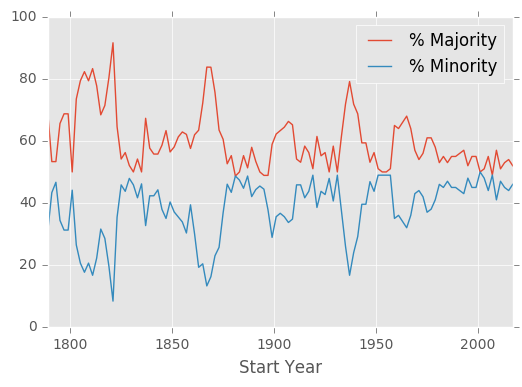

In [313]:
df[['% Majority','% Minority']].plot(x=df['Start Year'])

In [371]:
df_majority = df[['Majority Party', '% Majority', 'Start Year', 'End Year']]
df_minority = df[['Minority Party', '% Minority', 'Start Year', 'End Year']]

df_majority['Congress'] = df_majority.index
df_majority.rename(columns = {'Majority Party':'Party', '% Majority': 'Percent'}, inplace=True)
#df_majority.set_index('Majority Party', inplace=True)

df_minority['Congress'] = df_minority.index
df_minority.rename(columns = {'Minority Party':'Party', '% Minority': 'Percent'}, inplace=True)
#df_minority.set_index('Minority Party', inplace=True)
df_minority.head()

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Party,Percent,Start Year,End Year,Congress
Congress,,,,,
1st Congress,Anti-Administration,30.769231,1789,1791,1st Congress
2nd Congress,Anti-Administration,43.333333,1791,1793,2nd Congress
3rd Congress,Anti-Administration,46.666667,1793,1795,3rd Congress
4th Congress,Republican,34.375000,1795,1797,4th Congress
5th Congress,Republican,31.250000,1797,1799,5th Congress
6th Congress,Republican,31.250000,1799,1801,6th Congress
7th Congress,Federalist,44.117647,1801,1803,7th Congress
8th Congress,Federalist,26.470588,1803,1805,8th Congress
9th Congress,Federalist,20.588235,1805,1807,9th Congress


In [372]:
df_majority.head()

,Party,Percent,Start Year,End Year,Congress
Congress,,,,,
1st Congress,Pro-Administration,69.230769,1789,1791,1st Congress
2nd Congress,Pro-Administration,53.333333,1791,1793,2nd Congress
3rd Congress,Pro-Administration,53.333333,1793,1795,3rd Congress
4th Congress,Federalist,65.625000,1795,1797,4th Congress
5th Congress,Federalist,68.750000,1797,1799,5th Congress


In [461]:
parties = df_majority.append(df_minority)
#parties.set_index('Start Year', inplace=True)
group_parties = parties.groupby(by=parties['Party'])
parties.sort_values(by='Start Year', inplace=True)

In [436]:
parties['Party'].unique()

array(['Pro-Administration', 'Federalist', 'Republican',
       'Jackson & Crawford Republicans', 'Jacksonian', 'Anti-Jackson',
       'Democrat', 'Whig', 'Anti-Administration',
       'Adams-Clay Republicans & Federalists', 'Adams', 'Opposition'], dtype=object)

In [462]:
parties.head()

,Party,Percent,Start Year,End Year,Congress
Congress,,,,,
1st Congress,Pro-Administration,69.230769,1789,1791,1st Congress
1st Congress,Anti-Administration,30.769231,1789,1791,1st Congress
2nd Congress,Pro-Administration,53.333333,1791,1793,2nd Congress
2nd Congress,Anti-Administration,43.333333,1791,1793,2nd Congress
3rd Congress,Pro-Administration,53.333333,1793,1795,3rd Congress


In [429]:
import seaborn
seaborn.set(style='ticks')

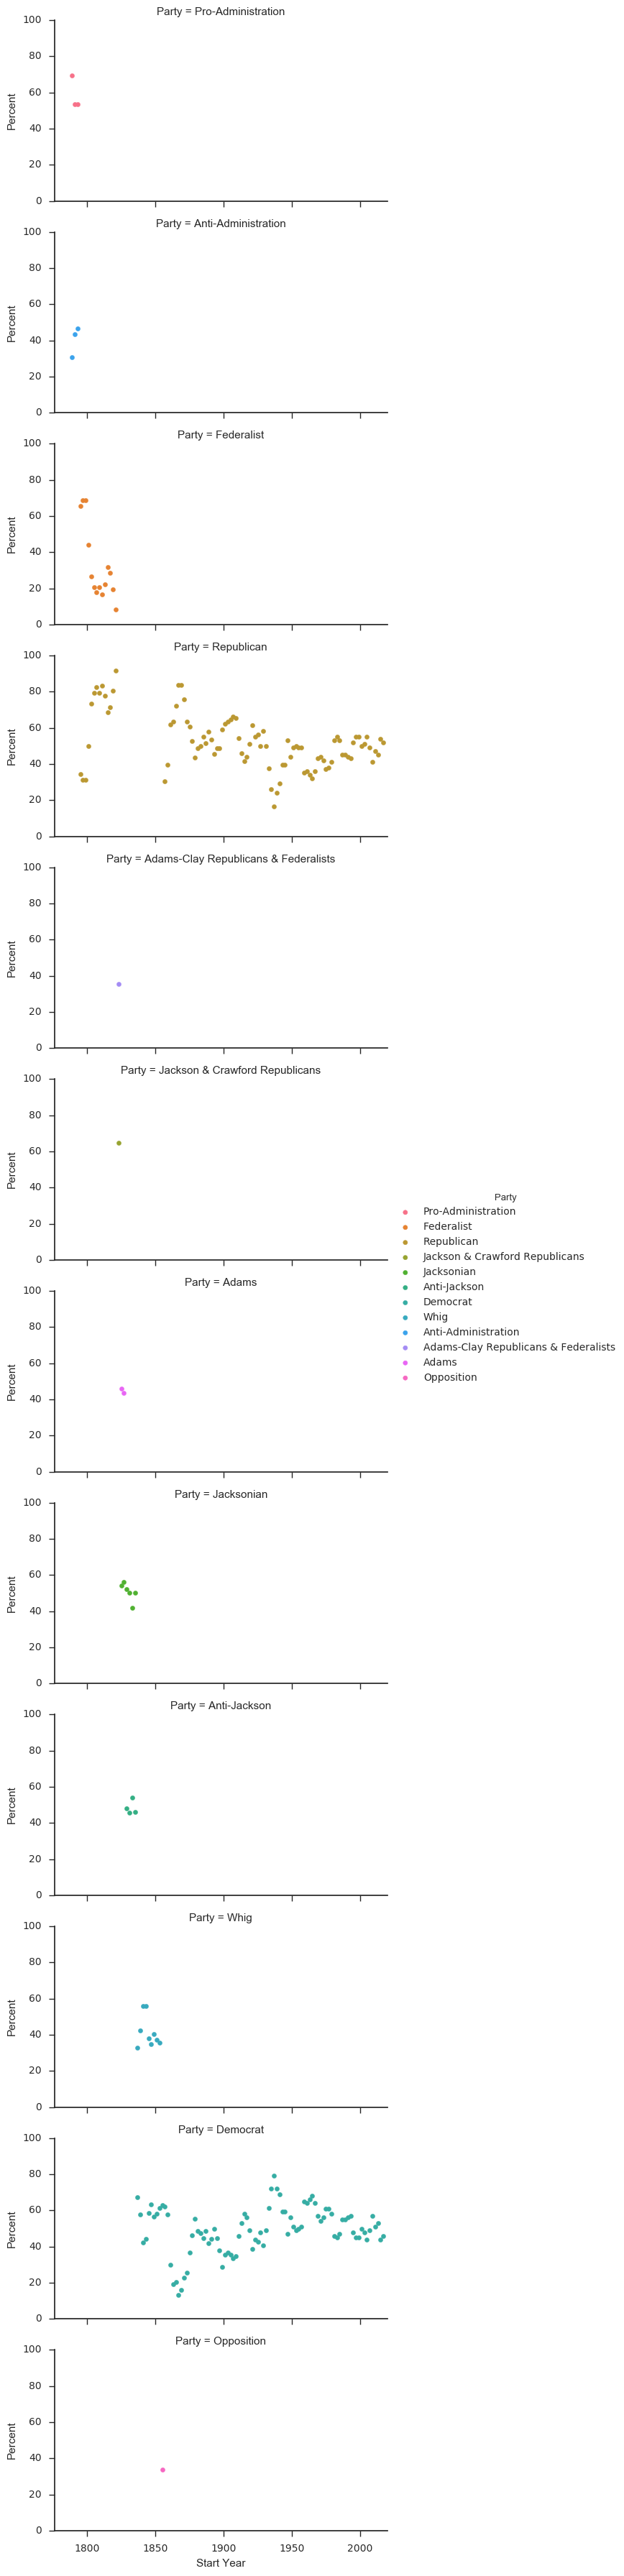

In [464]:
_parties = ['Pro-Administration', 'Federalist', 'Republican', 'Jackson & Crawford Republicans', 'Jacksonian',\
            'Anti-Jackson', 'Democrat', 'Whig', 'Anti-Administration', 'Adams-Clay Republicans & Federalists',\
            'Adams', 'Opposition']
fg = seaborn.FacetGrid(data=parties, row='Party', hue='Party', hue_order=_parties, aspect=2, ylim=(0,100),xlim=(1776, 2020))
fg.map(plt.scatter, 'Start Year', 'Percent').add_legend()

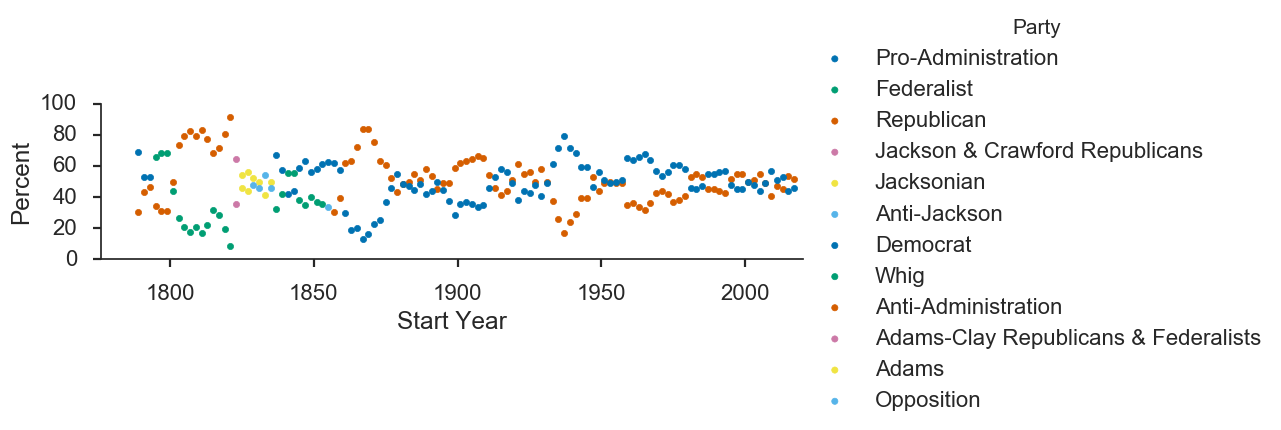

In [499]:
seaborn.set_context("poster")
plt.figure(figsize=(20, 8))
seaborn.set_palette(seaborn.color_palette("colorblind", 12))
fg = seaborn.FacetGrid(data=parties, hue='Party', hue_order=_parties, aspect=3, ylim=(0,100),xlim=(1776, 2020))
fg.map(plt.scatter, 'Start Year', 'Percent').add_legend()

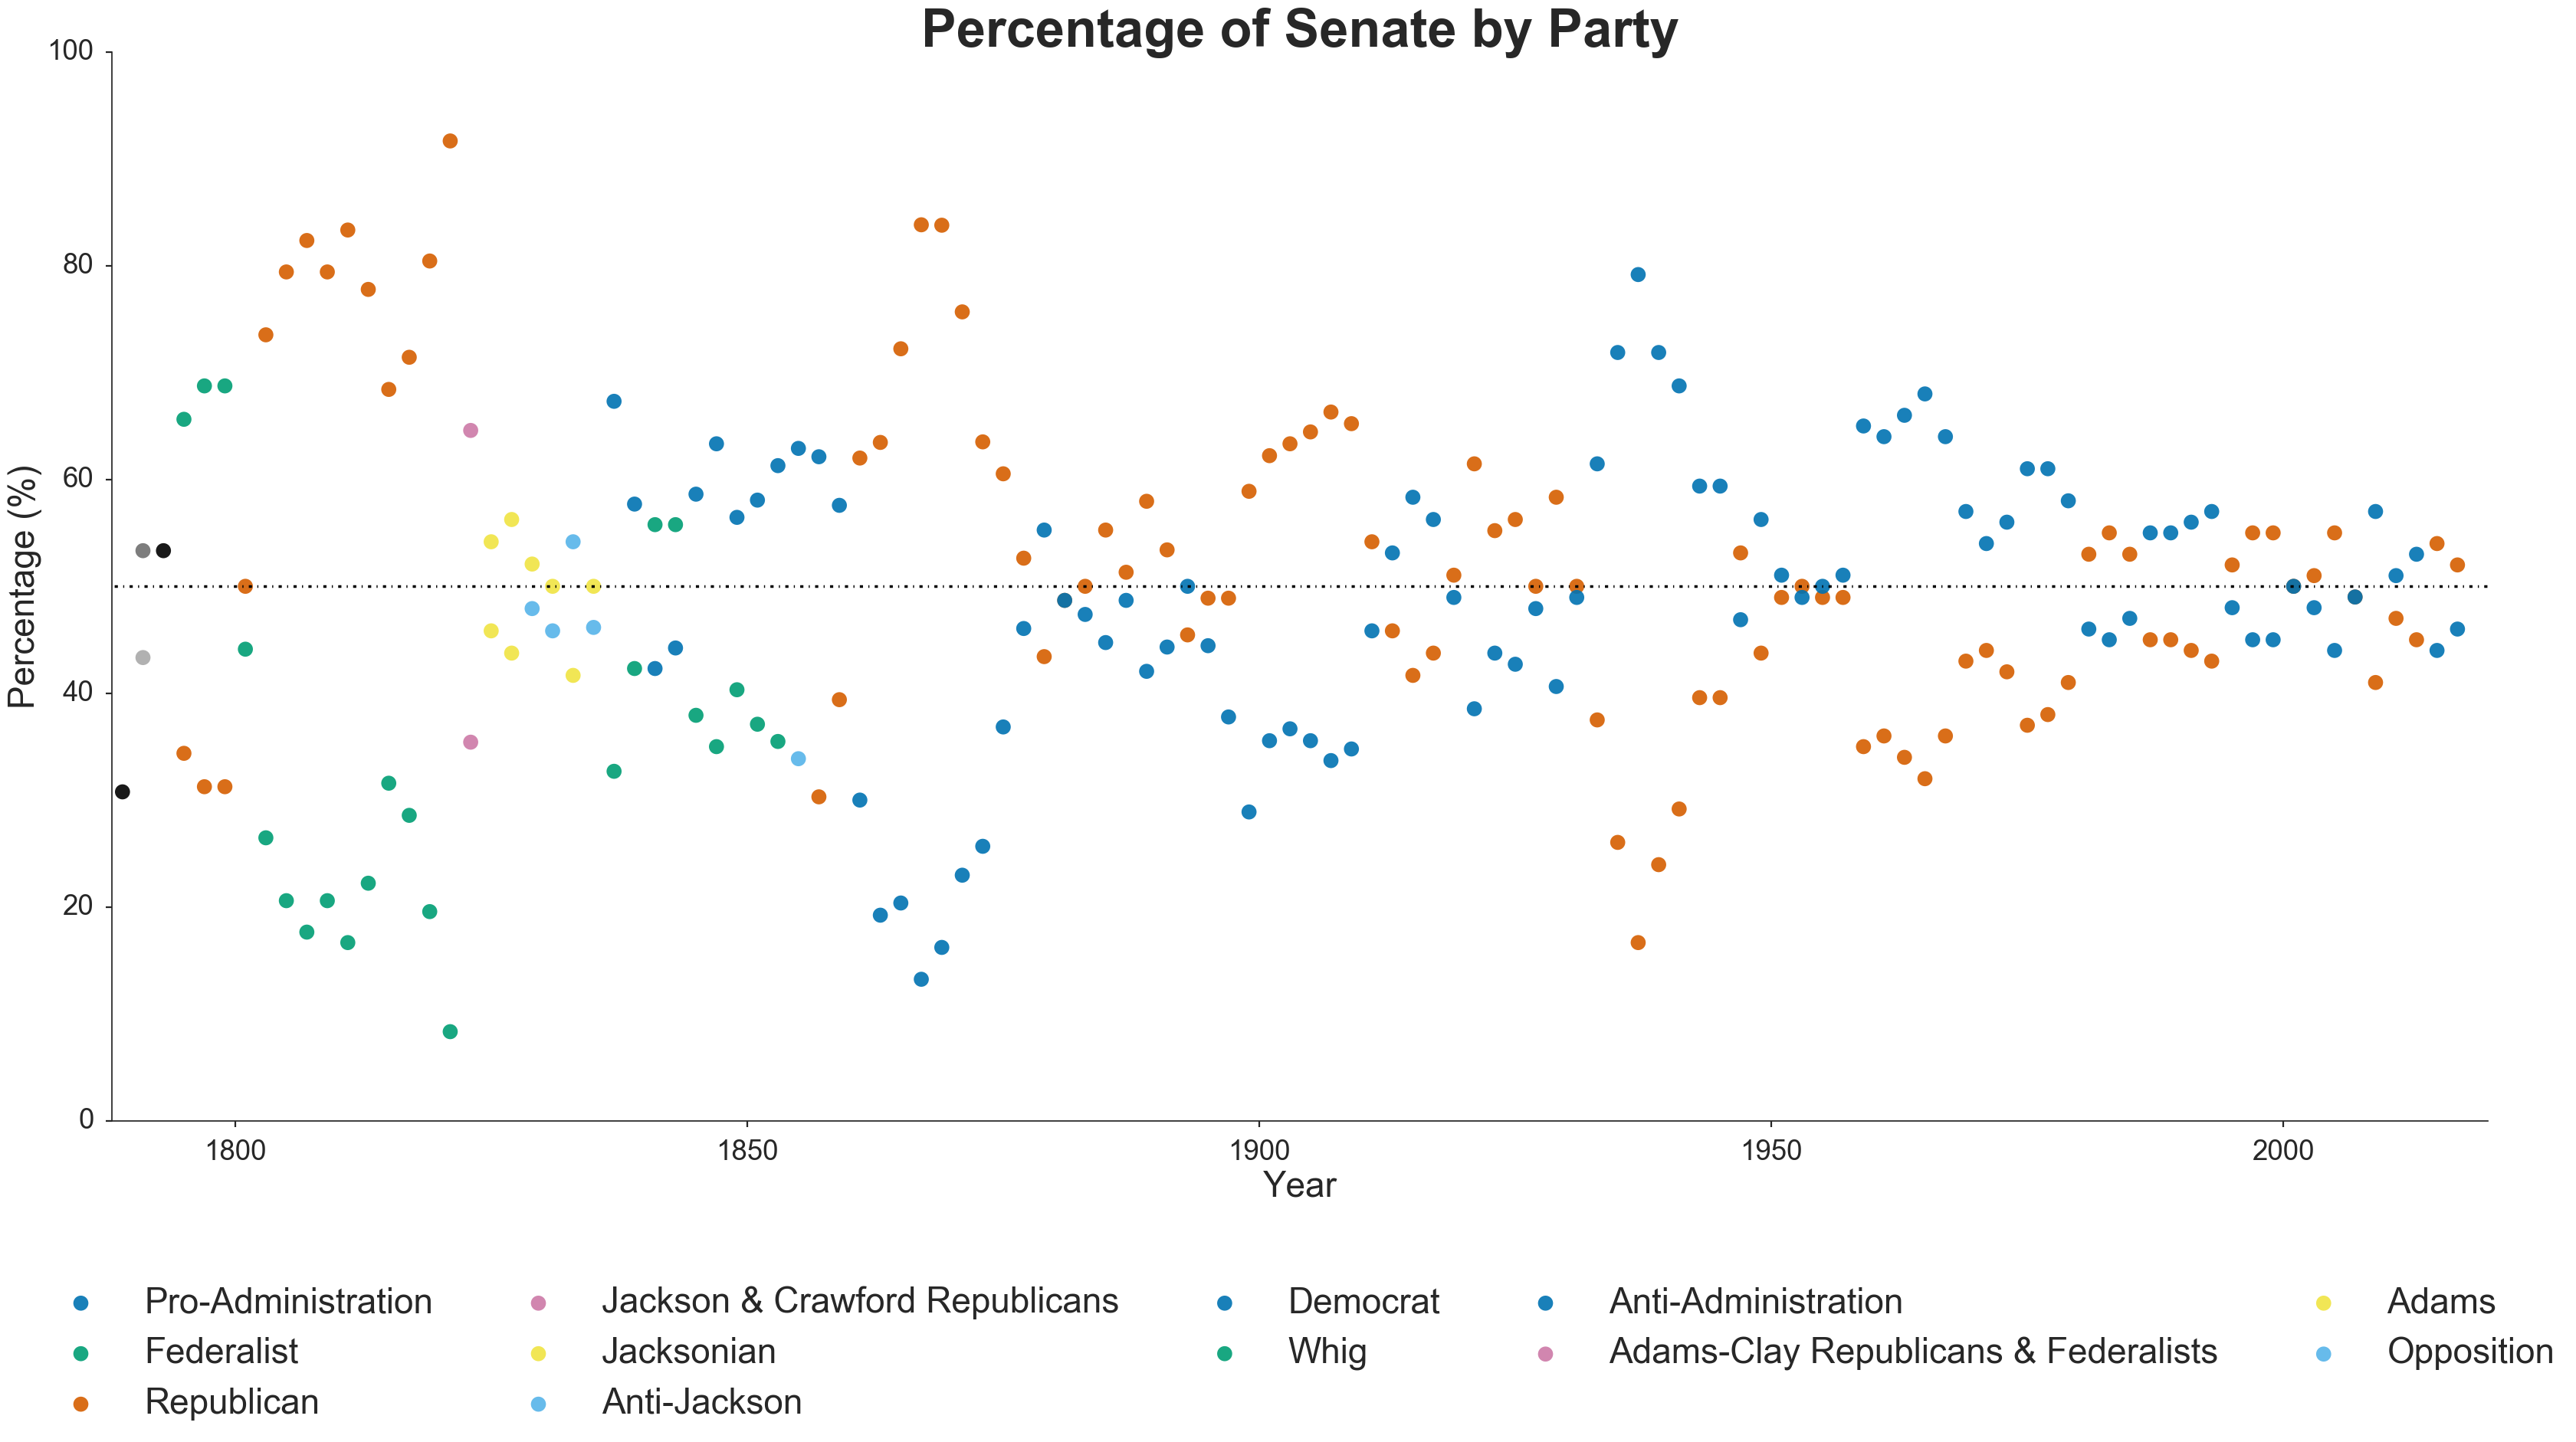

In [606]:
_parties = ['Pro-Administration', 'Federalist', 'Republican', 'Jackson & Crawford Republicans', 'Jacksonian',\
            'Anti-Jackson', 'Democrat', 'Whig', 'Anti-Administration', 'Adams-Clay Republicans & Federalists',\
            'Adams', 'Opposition']
_colors = seaborn.color_palette("colorblind", 12)
_party_color = {k: v for (k,v) in zip(_parties, _colors ,)}

fig, ax = plt.subplots(figsize=(40,20), dpi=600)
for party in _parties:
    x, y = parties[parties['Party'] == party]['Start Year'], parties[parties['Party'] == party]['Percent']
    ax.scatter(x, y, c=_party_color[party], s = 200, label=party, alpha=0.9, edgecolors='none')


labelsize = 33
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.125), ncol=5, fontsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.plot([1778, 2020], [50, 50], 'k-.', lw=2.5)
plt.tick_params(axis='both', which='major', labelsize=0.8*labelsize)
plt.title('Percentage of Senate by Party', fontsize=1.5*labelsize, fontweight='bold')
plt.xlabel('Year', fontsize=labelsize)
plt.ylabel('Percentage (%)', fontsize=labelsize)
plt.axis([1788, 2020, 0, 100])
plt.show()